# Download NIRCam images from MAST and run JWST pipeline

#### Select using program ID and specific NIRCam detectors

https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data  
https://github.com/ceers/ceers-nircam/blob/main/ceersdownload.py  

also see:  
https://spacetelescope.github.io/jdat_notebooks/notebooks/NIRSpec_MAST_Query/NIRSpec_MAST_Query.html  
https://mast.stsci.edu/api/        
https://github.com/gbrammer/mastquery/blob/master/mastquery/jwst.py  

### JWST file naming conventions

https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html

# If you know the filename, it's easy to download from MAST

In [1]:
from astroquery.mast import Observations
import os

In [2]:
mast_dir = 'mast:jwst/product' # Download from MAST

data_dir = 'data'  # save downloaded data
os.makedirs(data_dir, exist_ok=True)

In [3]:
image_file = "jw01345001001_10201_00001_nrca3_cal.fits"  # CEERS
mast_path  = os.path.join(mast_dir, image_file)
local_path = os.path.join(data_dir, image_file)
Observations.download_file(mast_path, local_path=local_path)

('COMPLETE', None, None)

# Or you can search the observations in MAST

In [36]:
import fnmatch

def fs(x, ndec):  # format_string
    if type(x) != str:
        fmt = '%%0%dd' % ndec
        x = fmt % x  # e.g., '%03d' % observation
    return x

def select_jwst_files(filename_list, program='?????', observation='???', visit='???', group='??', prime_parallel='?', activity='??', 
                      exposure='?????', detector='*', filetype='*', extension='fits', debug=False):
    #if type(observation) in (int, float):
    #program     = format_string(program, 5)
    #observation = format_string(observation, '%03d')
    #visit       = format_string('%03d' % visit)
    #exposure    = format_string('%05d' % exposure)
    #group       = format_string('%02d' % group)

    search_string = 'jw' + fs(program, 5) + fs(observation, 3) + fs(visit, 3) \
        + '_' + fs(group, 2) + prime_parallel + activity + '_' + fs(exposure, 5) \
        + '_' + detector + '_' + filetype + '.' + extension

    if debug:
        print(search_string)
    
    return fnmatch.filter(filename_list, search_string)

format_string(1, 3)  # test

'001'

In [22]:
from astropy.table import unique  # , Table, vstack

def query_jwst_files(proposal_id, download_datatype):  # , observation='???', detector='*'):
    # https://github.com/ceers/ceers-nircam/blob/main/ceersdownload.py 
    obs_table = Observations.query_criteria(obs_collection='JWST', proposal_id=[proposal_id], instrument_name=instrument, 
                                            dataproduct_type='IMAGE')  #filters=file_filters, 
    
    products_list = Observations.get_product_list(obs_table)  # all output products including images, catalogs, etc.
    
    products = Observations.filter_products(products_list, productType=['SCIENCE'], productSubGroupDescription=download_datatype)
    
    files = unique(products, keys='productFilename')
    all_filenames = files['productFilename']
    #chosen_files = select_jwst_files(all_filenames, observation=observation, detector=detector)
    
    return all_filenames

In [14]:
def download_jwst_files(filenames, save_dir):
    # Download data
    # https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data
    #manifest = Observations.download_products(chosen_obsIDs, download_dir=DOWNLOAD_DIR)  # , flat=True

    downloaded_files = []
    for filename in filenames:
        mast_path  = os.path.join(mast_dir,  filename)
        local_path = os.path.join(save_dir, filename)
        Observations.download_file(mast_path, local_path=local_path)
        downloaded_files.append(local_path)

    return downloaded_files

# JWST Science Calibration Pipeline
https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview  
https://jwst-pipeline.readthedocs.io  
`pip install jwst`

### Pipeline Stages
1. uncal –> rate
2. rate –> cal
3. cal –> i2d

In [6]:
import os
home = os.path.expanduser("~")
from glob import glob
import numpy as np
from astropy.io import fits

In [7]:
# Define CRDS paths *before* importing jwst pipeline
# otherwise you'll get FileNotFoundError: [Errno 2] : No such file or directory: '$HOME/crds_cache/config/jwst/server_config'

#os.environ["CRDS_PATH"] = "$HOME/crds_cache"
#os.environ["CRDS_PATH"] = '/grp/crds/cache/' at STScI
os.environ["CRDS_PATH"] = os.path.join(home, "crds_cache")
os.makedirs(os.environ['CRDS_PATH'], exist_ok=True)

os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"
print(os.environ['CRDS_PATH'])

/Users/dcoe/crds_cache


In [8]:
import jwst
from jwst.pipeline import Detector1Pipeline, Image2Pipeline
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.associations import asn_from_list
from jwst.pipeline import calwebb_image3
jwst.__version__

'1.11.4'

In [9]:
def reduce_jwst_files(uncal_files):
    for uncal_file in uncal_files:
        # Stage 1 Pipeline: uncal –> cal
        rate_file = uncal_file.replace('_uncal.fits', '_rate.fits')
        if os.path.exists(rate_file):
            print(rate_file, 'EXISTS')
        else:
            result1 = Detector1Pipeline()
            result1.jump.rejection_threshold = 10  # 21; default 4  https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/arguments.html
            result1.dark_current.skip = False
            result1.ipc.skip = False
            result1.persistence.skip = False
            result1.save_results = True
            result1.output_dir = images_dir
            result1.run(uncal_file)
    
        ## insert here: 1/f noise striping
    
        # Stage 2 Pipeline: rate –> cal
        cal_file = rate_file.replace('_rate.fits', '_cal.fits')    
        if os.path.exists(cal_file):
            print(cal_file, 'EXISTS')
        else:
            result2 = Image2Pipeline()
            result2.resample.skip = True  # Don't produce individual id2 images (rectified quick-look)
            result2.save_results = True
            result2.output_dir = images_dir
            result2.run(rate_file) # rate -> cal [, i2d]

    # Stage 3 Pipeline: cal –> i2d
    cal_files = [uncal_file.replace('_uncal.fits', '_cal.fits') for uncal_file in uncal_files]

    # Association file
    #outroot = 'jw04452' + '009'  # observation 9
    outroot = 'jw%05d%03d' % (proposal_id, observation)
    association_file = outroot+'_image_associations.json'
    association = asn_from_list.asn_from_list(cal_files, rule=DMS_Level3_Base, product_name=outroot, asn_rule='Asn_Image') #asn_type='image3')
    with open(association_file, 'w') as fh:
       fh.write(association.dump()[1])

    # Combine multiple exposures / dithers into one image
    m = calwebb_image3.Image3Pipeline()
    m.tweakreg.skip = True  # Turn off TweakRegStep 
    m.skymatch.skip = True  # Turn off SkyMatchStep
    m.outlier_detection.skip = False
    m.source_catalog.snr_threshold = 5  # 20
    m.source_catalog.output_file = outroot + "_cat.ecsv"
    m.save_results = True  # _i2d.fits
    m.output_dir = images_dir 
    m.resample.pixel_scale_ratio = 0.5  # input / output
    m.run(association_file)  # run the pipeline with these parameters on these images in association file; generate i2d.fits
    #m.save_model()  # generate i2d.fits in case you didn't set save_results = True above

In [80]:
def delete_extra_pipeline_output_files(images_dir):
    trash_files = glob('*_outlier_i2d.fits')
    trash_files += glob(os.path.join(images_dir, '*_crf.fits'))
    trash_files += glob(os.path.join(images_dir, '*_blot.fits'))
    trash_files += glob(os.path.join(images_dir, '*_median.fits'))
    trash_files += glob(os.path.join(images_dir, '*_trapsfilled.fits'))
    trash_files += glob(os.path.join(images_dir, '*_rateints.fits'))
    
    for trash_file in trash_files:
        os.remove(trash_file)

In [13]:
# Optional 1/f noise smoothing, simple method by Dan Coe

from astropy.stats import sigma_clipped_stats  # , SigmaClip
from astropy.convolution import convolve  # , Gaussian2DKernel, interpolate_replace_nans

def smooth_1overf_correction(data, row_kernel_length=99, column_kernel_length=9):
    # horizontal striping: y-axis row medians
    kernel = np.ones(row_kernel_length) / float(row_kernel_length)
    ymean, ymedian, ystd = sigma_clipped_stats(data, sigma=3, maxiters=10, axis=1)
    ymedian_conv = convolve(ymedian, kernel, boundary='extend')
    row_corrected_data = data + ymedian_conv[:,np.newaxis] - ymedian[:,np.newaxis]
    
    # vertical striping: x-axis column medians
    kernel = np.ones(column_kernel_length) / float(column_kernel_length)
    xmean, xmedian, xstd = sigma_clipped_stats(row_corrected_data, sigma=3, maxiters=10, axis=0)
    xmedian_conv = convolve(xmedian, kernel, boundary='extend')
    corrected_data = row_corrected_data + xmedian_conv[np.newaxis,:] - xmedian[np.newaxis,:]

    return corrected_data

# Start here

In [10]:
mast_dir = 'mast:jwst/product' # Download from MAST

# Define and create directory to save downloads
images_dir = 'images'
os.makedirs(images_dir, exist_ok=True)

instrument = 'NIRCAM/IMAGE'
download_datatype = 'UNCAL'  # options: UNCAL, RATE, CAL, I2D

In [ ]:
#image_file = "jw01345001001_10201_00001_nrca3_cal.fits"  # CEERS

In [ ]:
p = program ID
o = observation
v = visit
g = group
s: 1=prime; 2-5=parallel
a = activity (base 36)
e = exposure

jwpppppooovvv_ggsaa_eeeee
jw01345001001_10201_00001_nrca3_cal.fits

jwppppp ooo vvv_ggsaa_eeeee
jw01345 001 001_10201_00001_nrca3_cal.fits

In [18]:
# Select data
proposal_id = 1345  # Program number -- CEERS

In [25]:
all_uncal_files = query_jwst_files(proposal_id, download_datatype)

21

In [27]:
len(all_uncal_files)

1936

In [40]:
uncal_files = select_jwst_files(all_uncal_files, program=proposal_id, observation=1, visit=1, group=10, detector='nrca3', debug=True)
uncal_files

jw01345001001_10???_?????_nrca3_*.fits


['jw01345001001_10201_00001_nrca3_uncal.fits',
 'jw01345001001_10201_00002_nrca3_uncal.fits',
 'jw01345001001_10201_00003_nrca3_uncal.fits']

In [43]:
downloaded_files = download_jwst_files(uncal_files, images_dir)

In [44]:
downloaded_files

['images/jw01345001001_10201_00001_nrca3_uncal.fits',
 'images/jw01345001001_10201_00002_nrca3_uncal.fits',
 'images/jw01345001001_10201_00003_nrca3_uncal.fits']

In [ ]:
reduce_jwst_files(downloaded_files)

# Cleanup

In [87]:
delete_extra_pipeline_output_files(images_dir)

# Smooth 1/f noise

In [77]:
cal_files = [uncal_file.replace('_uncal.fits', '_cal.fits') for uncal_file in downloaded_files]
cal_files

['images/jw01345001001_10201_00001_nrca3_cal.fits',
 'images/jw01345001001_10201_00002_nrca3_cal.fits',
 'images/jw01345001001_10201_00003_nrca3_cal.fits']

In [ ]:
smooth1ovef_files = []
for i, input_file in enumerate(cal_files):
    #print(input_file)
    hdu_list = fits.open(input_file)
    data = hdu_list['SCI'].data
    #data = fits.getdata(input_file)
    #data = np.nan_to_num(data)  # replace nan with zero
    output_file = input_file.replace('cal.fits', 'cal1f.fits')
    print(output_file)
    if not os.path.exists(output_file):
        corrected_data = smooth_1overf_correction(data)
        hdu_list['SCI'].data = corrected_data
        hdu_list.writeto(output_file)
        #fits.PrimaryHDU(corrected_data).writeto(output_file)
    smooth1ovef_files.append(output_file)

In [ ]:
# Association file
#outroot = 'jw04452' + '009'  # observation 9
outroot = 'jw%05d%03d_smooth1overf' % (proposal_id, observation)
association_file = outroot+'_image_associations.json'
association = asn_from_list.asn_from_list(smooth1ovef_files, rule=DMS_Level3_Base, product_name=outroot, asn_rule='Asn_Image') #asn_type='image3')
with open(association_file, 'w') as fh:
   fh.write(association.dump()[1])

# Combine multiple exposures / dithers into one image
m = calwebb_image3.Image3Pipeline()
m.tweakreg.skip = True  # Turn off TweakRegStep 
m.skymatch.skip = True  # Turn off SkyMatchStep
m.outlier_detection.skip = False
m.source_catalog.snr_threshold = 5  # 20
m.source_catalog.output_file = outroot + "_cat.ecsv"
m.save_results = True  # _i2d.fits
m.output_dir = images_dir 
m.resample.pixel_scale_ratio = 0.5  # input / output
m.run(association_file)  # run the pipeline with these parameters on these images in association file; generate i2d.fits
#m.save_model()  # generate i2d.fits in case you didn't set save_results = True above

In [81]:
delete_extra_pipeline_output_files(images_dir)

In [72]:
import matplotlib.pyplot as plt

def display_images(image_data, corrected_data, vmin, vmax, corrected_title, filename, xsize=12, ysize=12, aspect=1, cmap='viridis',
                  save_plot=None, dpi=150):
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('axes',  labelsize=10)
    plt.rc('axes',  titlesize=12)
    
    fig, axs = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True, layout='compressed')
    axs = axs.flatten()
    
    plot_data = image_data, corrected_data
    
    for i in range(2):
        data = plot_data[i]
        data = np.nan_to_num(data)  # replace nan with zero
        im = axs[i].imshow(data, vmin=vmin, vmax=vmax, origin='lower')
    
    axs[0].set_title(os.path.basename(filename), fontsize=12)
    axs[1].set_title(corrected_title, fontsize=12)
    
    plt.colorbar(im, ax=axs, label='MJy/sr')
    
    if save_plot:
        output_file = save_plot
        plt.savefig(output_file, dpi=dpi)

In [88]:
outroot

'jw01345001_smooth1overf'

In [89]:
inroot = outroot.replace('_smooth1overf', '')
inroot

'jw01345001'

In [90]:
data      = fits.getdata(os.path.join(images_dir,  inroot+'_i2d.fits'))
corrected = fits.getdata(os.path.join(images_dir, outroot+'_i2d.fits'))

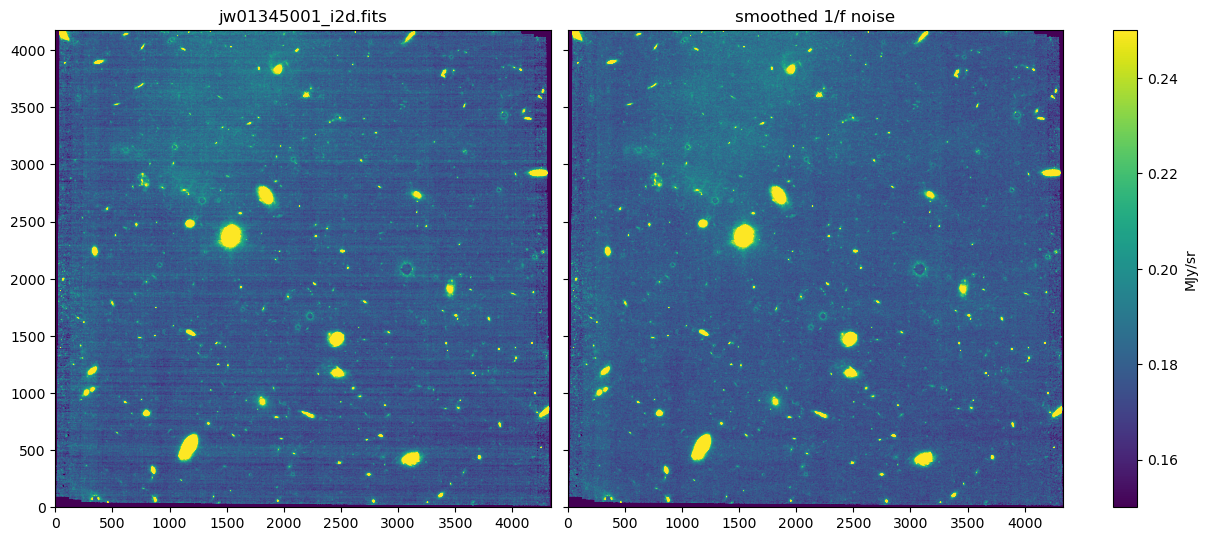

In [91]:
#vmin, vmax = -0.02, 0.5
vmin, vmax = 0.15, 0.25
display_images(data, corrected, vmin, vmax, 'smoothed 1/f noise', 'jw01345001_i2d.fits')